In [1]:
import pandas as pd
import re
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from navec import Navec
path = r"C:\Users\User\Documents\github\He_who_laughs_last\data\embedded\navec.tar"
navec = Navec.load(path)

In [2]:
def preprocess_read_russia(jk):
    res = []
    for i in tqdm(jk):
        clean_text = re.sub(r'(?:(?!\u0301)[\W\d_])+', ' ', i)
        res.append(clean_text.split())
    return res

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

def pad_data(data,target,mode='embed'):
    if mode !='embed':
        for i in tqdm(range(len(data))):
            if(len(data[i]) == target):
                continue
            elif(len(data[i]) < target):
                while len(data[i]) != target:
                    data[i].append(0)
            elif(len(data[i]) > target):
                data[i] = data[i][:target]
        return data
    else:
        for i in tqdm(range(len(data))):
            if(len(data[i]) == target):
                continue
            elif(len(data[i]) < target):
                while len(data[i]) != target:
                    data[i].append(navec['<pad>'])
            elif(len(data[i]) > target):
                data[i] = data[i][:target]
        return data

def embed_navec(data):
    embedded = []
    for i in tqdm(range(len(data))):
        emb = []
        for word in data[i]:
            if(navec.get(word) is None):
                emb.append(navec['<unk>'])
            else:
                emb.append(navec[word])
        embedded.append(emb)
    return embedded

<Axes: ylabel='Frequency'>

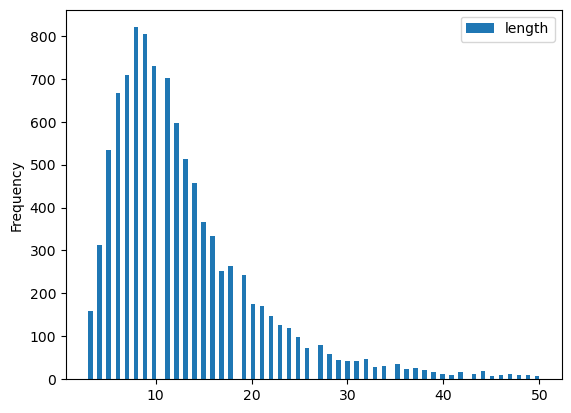

In [16]:
jokes_raw[jokes_raw.length <=50].sample(n=10000,random_state=42).plot(kind='hist',bins=100)

## Больше 90% анекдотов имеют длину <= 40, имеет смысл отсечь по 30 или 40 датасет
### Как реализую сейчас - размер одного образца датасета других текстов на 30
#### UPD. Что было сделано:
- Использован эмбединг Navec для шуток и новостных статей
- Решено пока эмбедить по id слов, так как иначе - супер много память ( > 25 гб для статей )
- В итоге размерность векторов = 30
- Размерность выборок: 250к - анекдоты, 200к - статьи

In [61]:
print(jokes_raw['length'].quantile(0.95))


31.0


# Подготовка датасета к использованию классическими моделями
### *Идея - с помощью PCA уменьшить размерность каждого образца с 9000 координат до ~ 120 координат на каждый образец*
### *Для моделей глубокого обучения планируется использовать весь датасет + делать отдельные dataset + dataloader*

In [4]:
jokes_raw = pd.read_pickle(r"C:\Users\User\Documents\large datasets\russian_jokes_navec.df")
non_jokes = pd.read_pickle(r"C:\Users\User\Documents\large datasets\padded_news.df")

In [22]:
def preprocess_compact(data, target_len ):
    from sklearn.decomposition import PCA 
    '''
    Uses PCA to shorten the embedded vectors
    Params:
    data - your initial vectors of form [[[embed1],[embed2]...]...]
    target_len - target len of one data row in the resulting data array. Needed for computing PCA components
    Returns:
    data in the form [[new_vector1],...] where len(new_vector) = target_len

    '''
    num_of_c = target_len//len(data[0])
    pca = PCA(n_components=num_of_c)
    res = []
    for i in tqdm(data):
        temp_res = pca.fit_transform(i)
        temp_res = [j for k in temp_res for j in k] 
        res.append(temp_res)
    return res

In [10]:
jokes_pca = preprocess_compact(jokes_raw['embedded_new'],120)
non_jokes_pca = preprocess_compact(non_jokes['embedded'],120)
non_jokes_pca = pd.DataFrame(non_jokes_pca)
jokes_pca_df = pd.DataFrame(jokes_pca)

 31%|███       | 81662/264133 [01:53<04:20, 700.03it/s]c:\Users\User\miniconda3\envs\myenv\lib\site-packages\sklearn\decomposition\_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
100%|██████████| 264133/264133 [06:05<00:00, 721.68it/s]


In [ ]:
# creating target, 1 - joke, 0 - not joke
non_jokes_pca['target'] = 0
jokes_pca_df['target'] = 1

In [14]:
jokes_pca_df.to_pickle(r"C:\Users\User\Documents\large datasets\russian_jokes_pca.df")
non_jokes_pca.to_pickle(r"C:\Users\User\Documents\large datasets\russian_news_pca.df")

In [32]:
# creating balanced dataset for classification
common = pd.concat([non_jokes_pca[:100000],jokes_pca_df[:100000]])
common = common.reset_index()
common.drop('index',axis=1,inplace=True)
common.to_pickle(r"C:\Users\User\Documents\large datasets\classic_data.df")

# Итоги:
- Все тексты были преобразованы с PCA до размера 120 на экземпляр и сохранены отдельно с таргетами
- Был сформирован датасет из 100к шуток и 100к не шуток для классических моделе1
- Были сформированы отдельные датасеты с полными эмбеддингами Navec размерности 300 на каждое слово для моделей глубокого обучения + backup
- Были сформированы функции и regexp для формирования лемматизированных текстов на русском языке ( из полностью сырых до embedded )